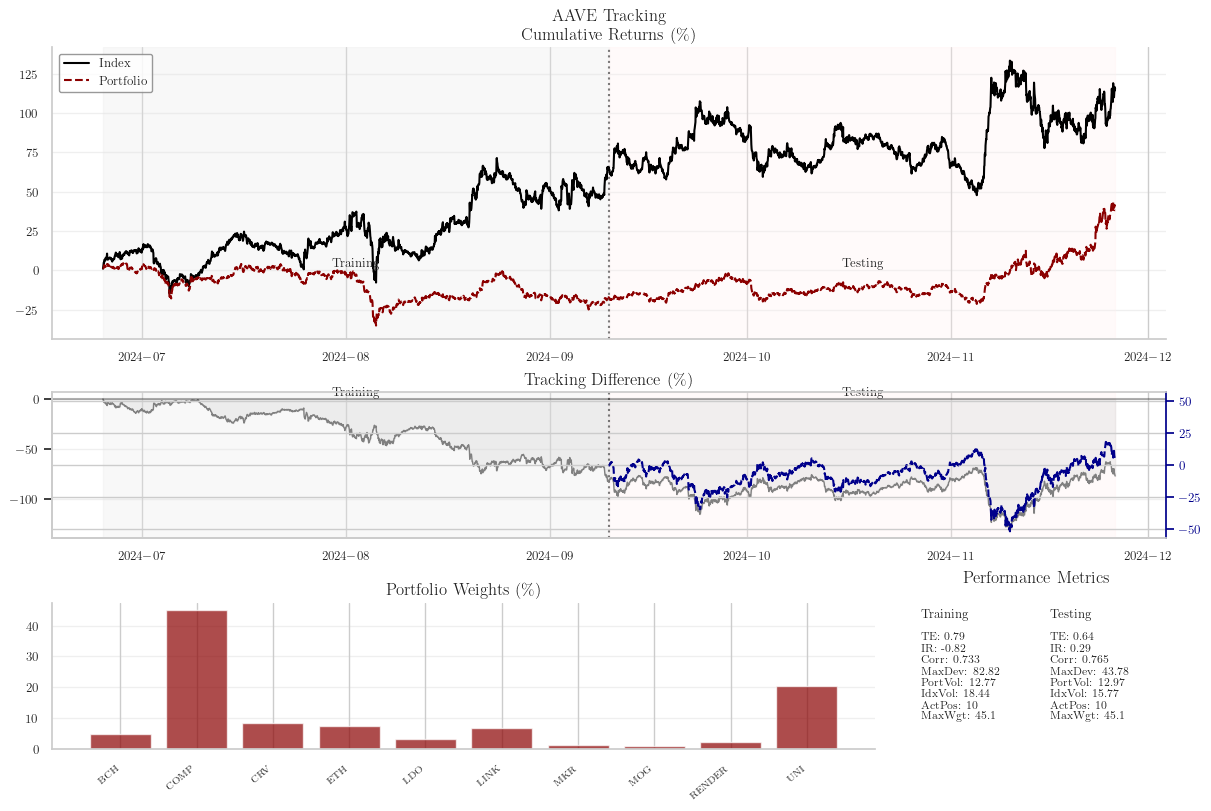

In [1]:
from replicate.data.loading import DataLoader
from replicate.data.analysis import train_test_split_data, analyze_train_test_results
from replicate.optimizers.mm import MMOptimizer

# Initialize loader and optimizer
loader = DataLoader()

def generate_results(data, measure='ete'):
    optimizer = MMOptimizer(measure=measure)
    result_dict = optimizer.optimize(
        data['train']['X'], 
        data['train']['r'], 
        lambda_=1e-7, 
        u=0.5, 
        p_neg_exp=8, 
        thres=1e-3,
        hub=0.5
    )
    train_metrics, test_metrics = analyze_train_test_results(
        train_data=data['train'],
        test_data=data['test'],
        weights=result_dict['weights'],
        asset_names=data['asset_names'],
        title_prefix=f"{sym} Tracking",
        plot_combined=True
    )


sym = 'AAVE'
START_DATE = "2024-06-25"
END_DATE = "2024-11-25"

data = train_test_split_data(
    loader=loader,
    data_type=DataLoader.CRYPTO_RETURNS,
    target_symbol=sym,
    train_pct=0.5,
    start_date=START_DATE,
    end_date=END_DATE,
    time_col='timestamp'
)

generate_results(data, measure='ete')

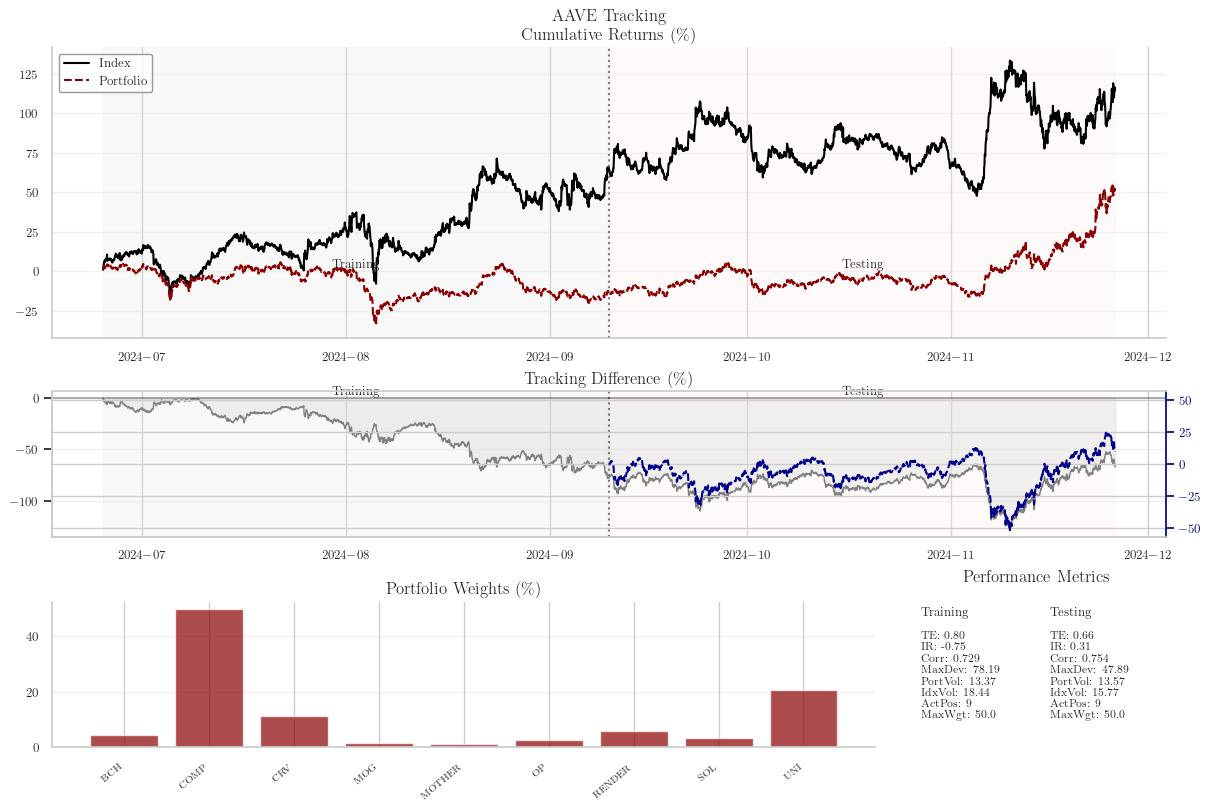

In [2]:
generate_results(data, measure='dr')

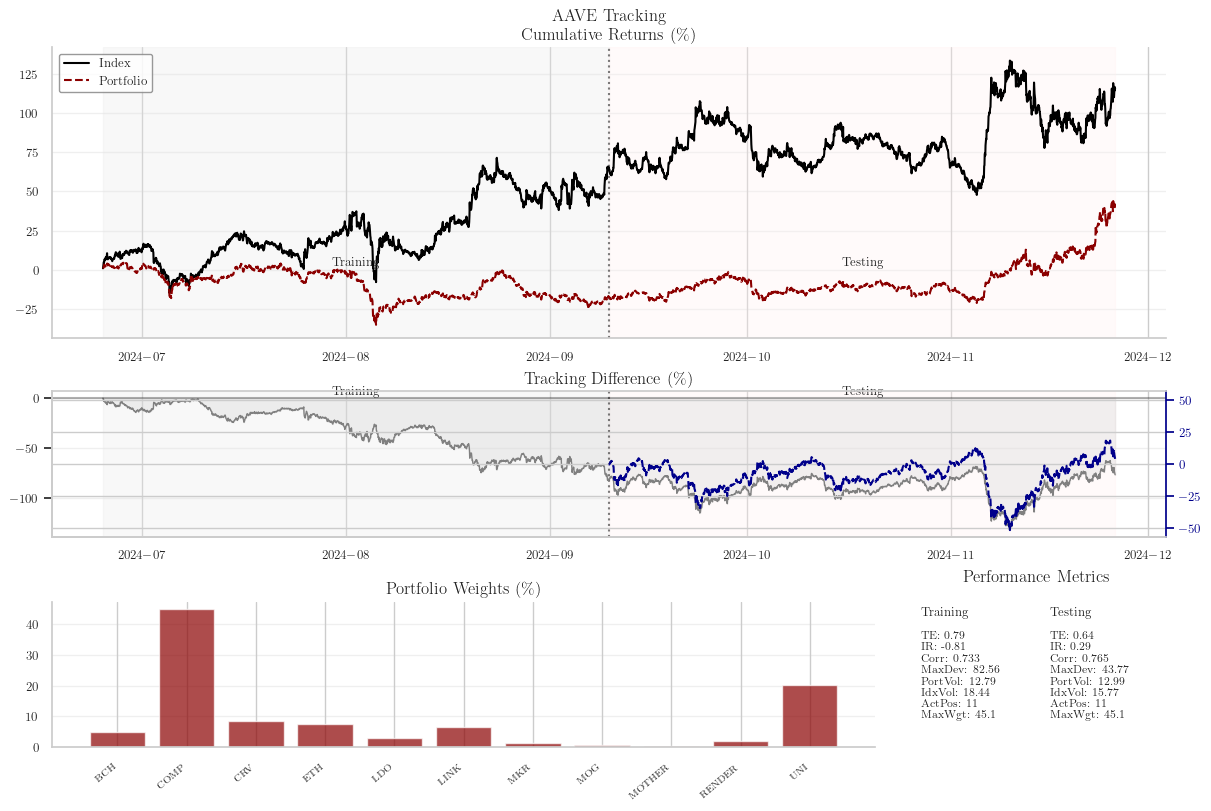

In [3]:
generate_results(data, measure='hete')

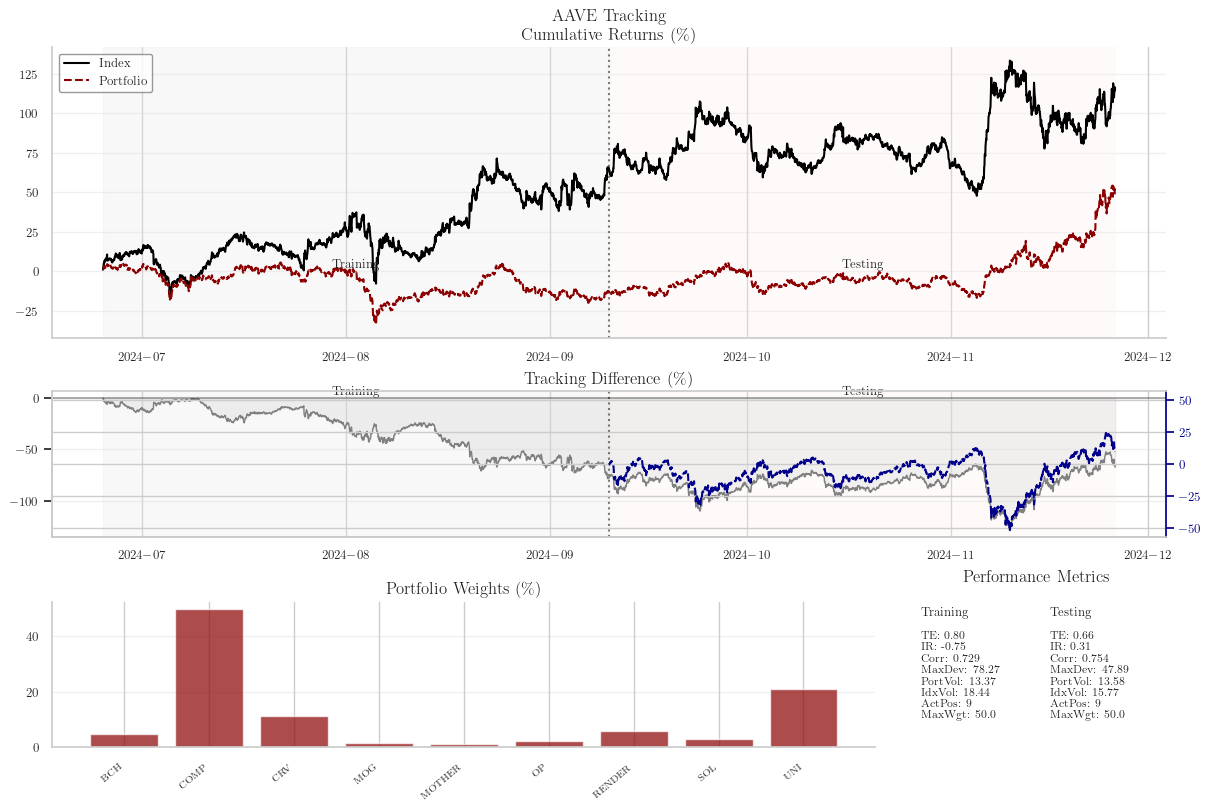

In [4]:
generate_results(data, measure='hdr')